In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

plt.rcParams['figure.figsize'] = [15, 10]

# Reading from NY2 dataset
# dataset_file = "C:\\Users\\Avell\\Desktop\\ITA\\Tese mestrado\\SegmentationDataset\\dataset.mat" # Windows
dataset_file = "/home/lmariga/githubp/datasets/NY2.mat"

f = h5py.File(dataset_file, 'r')
images = np.array(f.get('images')).T
labels = np.array(f.get('labels')).T
print(images.shape)
print(labels.shape)
print(f.keys())
plt.subplot(2, 2, 1)
plt.title('RGB')
plt.imshow(images[:,:,:,0])
plt.subplot(2, 2, 2)
plt.title('Labels')
plt.imshow(labels[:,:,0])
plt.subplot(2, 2, 3)
plt.title('RGB')
plt.imshow(images[:,:,:,4])
plt.subplot(2, 2, 4)
plt.title('Labels')
plt.imshow(labels[:,:,4])
plt.show()

/home/lmariga/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lmariga/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lmariga/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lmariga/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [2]:
# We take the labels list
data = []
for column in f['names']:
        row_data = []
        for row_number in range(len(column)):            
            row_data.append(''.join(map(chr, f[column[row_number]][:])))   
        data.append(row_data)
listanomes = data[0]

print(listanomes)


['book', 'bottle', 'cabinet', 'ceiling', 'chair', 'cone', 'counter', 'dishwasher', 'faucet', 'fire extinguisher', 'floor', 'garbage bin', 'microwave', 'paper towel dispenser', 'paper', 'pot', 'refridgerator', 'stove burner', 'table', 'unknown', 'wall', 'bowl', 'magnet', 'sink', 'air vent', 'box', 'door knob', 'door', 'scissor', 'tape dispenser', 'telephone cord', 'telephone', 'track light', 'cork board', 'cup', 'desk', 'laptop', 'air duct', 'basket', 'camera', 'pipe', 'shelves', 'stacked chairs', 'styrofoam object', 'whiteboard', 'computer', 'keyboard', 'ladder', 'monitor', 'stand', 'bar', 'motion camera', 'projector screen', 'speaker', 'bag', 'clock', 'green screen', 'mantel', 'window', 'ball', 'hole puncher', 'light', 'manilla envelope', 'picture', 'mail shelf', 'printer', 'stapler', 'fax machine', 'folder', 'jar', 'magazine', 'ruler', 'cable modem', 'fan', 'file', 'hand sanitizer', 'paper rack', 'vase', 'air conditioner', 'blinds', 'flower', 'plant', 'sofa', 'stereo', 'books', 'exit

In [3]:
# We can select the classes we want
class_floor = ['floor']
class_verticalPlanes = ['wall']
class_ceiling = ['ceiling']
class_structures = ['cabinet', 'refridgerator', 'table', 'door', 'desk', 'shelves', 'stacked chairs', 'whiteboard', 'window', 'bookshelf', 'column', 'wall divider', 'curtain'] # doors, windows, and other things that usually does not move

class_big_object = ['chair', 'cone', 'fire extinguisher', 'garbage bin', 'microwave', 'box', 'laptop', 'basket', 'computer', 'keyboard', 'monitor', 'ball', 'printer', 'fax machine','backpack']
class_small_object = ['book', 'bottle', 'paper', 'pot', 'bowl', 'scissor', 'cup', 'camera', 'bag', 'clock', 'picture', 'books', 'eraser', 'pencil holder', 'mouse', 'paper cutter', 'tape', 'circuit breaker box', 'paper towel', 'stamp','telephone', 'wire', 'head phones', 'mug holder', 'envelopes']

allowed_labels = class_verticalPlanes#+class_floor + class_ceiling + class_structures + class_big_object + class_small_object

# Finding indexes
allowed_labels_indexes = []
for i in allowed_labels: 
    allowed_labels_indexes.append(listanomes.index(i))

print(allowed_labels)
print(len(allowed_labels))
print(allowed_labels_indexes)

['wall']
1
[20]


In [4]:
# Exclui labels não usadas para treinar
labelsFinal = np.copy(labels)

super_threshold_indices = np.isin(labelsFinal, np.asarray(allowed_labels_indexes)+1, invert=True)
labelsFinal[super_threshold_indices] = 0
print(np.min(labelsFinal))

0


In [5]:
# Cria nova ordem numérica para as labels [1, 2, 3 ....]
def replace_with_dict2_generic(ar, dic, assume_all_present=0):
    # Extract out keys and values
    k = np.array(list(dic.keys()))
    v = np.array(list(dic.values()))

    # Get argsort indices
    sidx = k.argsort()

    ks = k[sidx]
    vs = v[sidx]
    idx = np.searchsorted(ks,ar)

    if assume_all_present==0:
        idx[idx==len(vs)] = 0
        mask = ks[idx] == ar
        return np.where(mask, vs[idx], ar)
    else:
        return vs[idx]
dictrans = {}
for i in range(len(allowed_labels_indexes)): 
    dictrans[allowed_labels_indexes[i]+1] = i+1
    

labelsFinal = replace_with_dict2_generic(labelsFinal, dictrans, False)
print(dictrans)
print(allowed_labels)

{21: 1}
['wall']


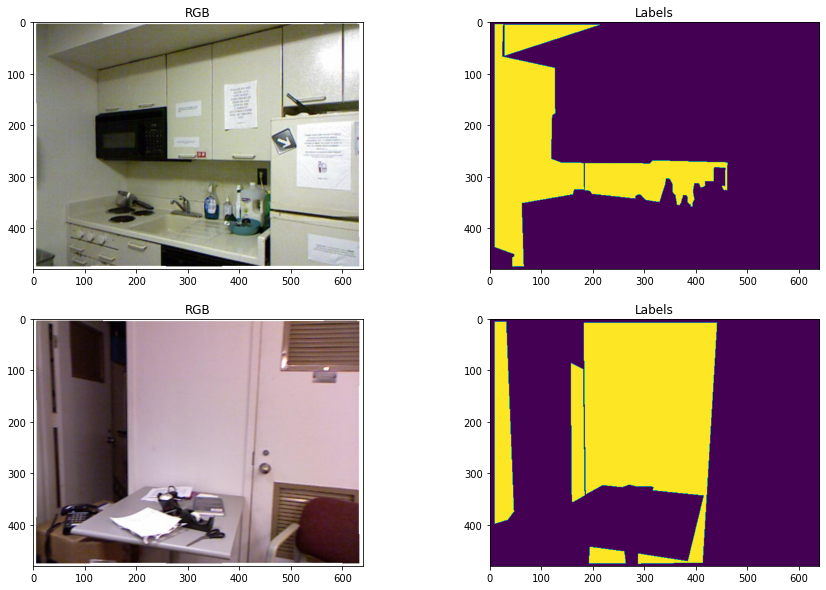

In [6]:
plt.subplot(2, 2, 1)
plt.title('RGB')
plt.imshow(images[:,:,:,1])
plt.subplot(2, 2, 2)
plt.title('Labels')
plt.imshow(labelsFinal[:,:,1])
plt.subplot(2, 2, 3)
plt.title('RGB')
plt.imshow(images[:,:,:,2])
plt.subplot(2, 2, 4)
plt.title('Labels')
plt.imshow(labelsFinal[:,:,2])
plt.show()

# PREPARING THE CNN

In [ ]:


def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, nclasses=1, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(nclasses, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Number of classes
num_classes = np.max(labelsFinal)